## Filtro Colaborativo basado en elementos

In [1]:
#Librerias a cargar 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from scipy.sparse.linalg import svds


In [2]:
#Cargar los datos 
df = pd.read_csv("D:/difods/py004_recomendacion/data/moviesp.csv", sep=",")

In [3]:
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [4]:
df[df['movieId']==193609]

,userId,movieId,rating,timestamp,title,genres
97083,331,193609,4.0,1537157606,Andrew Dice Clay: Dice Rules (1991),Comedy


In [5]:
# Pivot de la tabla inicial solo usando las columnas de userId, movieId y rating
df_pivot = df.pivot(index='userId', columns='movieId', values= 'rating')
df_pivot.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Matrix sparsity
spartity_count = df_pivot.isnull().values.sum()
# Contar todas las celdas
full_cont = df_pivot.size
# Numero de escazes del dataset
sparsity = round(spartity_count / full_cont,3)
print('El dataset tiene una escasez de : ' + str(sparsity*100) + '%')

El dataset tiene una escasez de : 98.3%


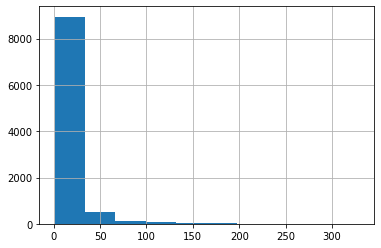

In [7]:
# Contar las celdas ocupadas por columna
count_celdas_ocupadas = df_pivot.notnull().sum()
# Ordenar el resultado de mayot a menor
sorted_count_celdas_ocupadas = count_celdas_ocupadas.sort_values()
# Plot Histograma
sorted_count_celdas_ocupadas.hist()
plt.show()

Descomposición de valores singulares (SVD)

In [8]:
#Obtener la valoración media de cada usuario
avg_rating = df_pivot.mean(axis=1)
#Centrar las valoraciones de los usuarios entorno a 0
df_pivot_centered = df_pivot.sub(avg_rating, axis=0)
#Rellenar los datos que faltan con 0
df_pivot_centered.fillna(0, inplace=True)
# Comprobar la matriz centrada
print(df_pivot_centered.mean(axis=1))

userId
1      4.384262e-18
2      6.393715e-19
3      7.307103e-19
4      4.566940e-18
5      5.023634e-19
           ...     
606   -1.899847e-17
607   -3.653552e-19
608    1.315279e-17
609    3.653552e-19
610   -1.644098e-17
Length: 610, dtype: float64


In [9]:
#Descomponer la Matrix
U, sigma, Vt = svds(df_pivot_centered)
#Converitir el sigma en la diagonal de la matriz
sigma = np.diag(sigma)

In [10]:
#Producto de puntos
U_sigma = np.dot(U,sigma)
#Producto de puntos del resultado
U_sigma_Vt = np.dot(U_sigma, Vt)
#Añadiendo las medias de las filas contenidas
Calificaciones_descentradas = U_sigma_Vt + avg_rating.values.reshape(-1,1)

calc_pred_df = pd.DataFrame(Calificaciones_descentradas,
                            index=df_pivot.index,
                            columns=df_pivot.columns)

print(calc_pred_df)




movieId    1         2         3         4         5         6         7       \
userId                                                                          
1        4.462314  4.349185  4.389132  4.355828  4.304889  4.379954  4.339853   
2        3.947867  3.948730  3.943345  3.948975  3.954781  3.955014  3.950488   
3        2.406305  2.439618  2.420748  2.440964  2.468875  2.461135  2.451152   
4        3.616146  3.556886  3.576326  3.551370  3.500886  3.497739  3.521390   
5        3.653970  3.633074  3.646911  3.631662  3.620151  3.628583  3.628683   
...           ...       ...       ...       ...       ...       ...       ...   
606      3.897556  3.566707  3.688992  3.599346  3.434501  3.736443  3.544275   
607      3.818336  3.773703  3.799590  3.778775  3.742178  3.779247  3.769289   
608      3.446540  2.838885  2.682081  3.117258  2.706645  3.795240  2.909024   
609      3.286156  3.265451  3.271643  3.267343  3.260062  3.277101  3.266075   
610      4.285995  3.569007 

In [11]:
# Ordenar la valoración del usuario 5 de mayor a menor 
user_100_ratings = calc_pred_df.iloc[0,:].sort_values(ascending=False)
print(user_100_ratings)

movieId
296     4.656916
318     4.636322
527     4.596006
858     4.591951
356     4.591609
          ...   
3623    4.236417
2701    4.232019
780     4.226218
788     4.220601
2628    4.210017
Name: 1, Length: 9724, dtype: float64


Validando las predicciones

In [12]:
#Comparar los metodos de recommendación 
#Extraer los valores verdaderos del dataset para comparar las predicciones
actual_valor = df_pivot.iloc[:20, :100].values
predict_values = calc_pred_df.iloc[:20, :100].values 

In [13]:
mask = ~np.isnan(actual_valor)

In [14]:
print(mean_squared_error(actual_valor[mask], predict_values[mask],squared=False))

0.8921426869616678


In [15]:
calc_pred_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.462314,4.349185,4.389132,4.355828,4.304889,4.379954,4.339853,4.353081,4.371022,4.304191,...,4.366366,4.366333,4.366399,4.366399,4.366366,4.366399,4.366366,4.366366,4.366366,4.366969
2,3.947867,3.948730,3.943345,3.948975,3.954781,3.955014,3.950488,3.949590,3.946458,3.960781,...,3.948267,3.948247,3.948288,3.948288,3.948267,3.948288,3.948267,3.948267,3.948267,3.948270
3,2.406305,2.439618,2.420748,2.440964,2.468875,2.461135,2.451152,2.439374,2.424418,2.481790,...,2.435862,2.435774,2.435949,2.435949,2.435862,2.435949,2.435862,2.435862,2.435862,2.435745
4,3.616146,3.556886,3.576326,3.551370,3.500886,3.497739,3.521390,3.555289,3.562753,3.490580,...,3.555621,3.555780,3.555462,3.555462,3.555621,3.555462,3.555621,3.555621,3.555621,3.555394
5,3.653970,3.633074,3.646911,3.631662,3.620151,3.628583,3.628683,3.635113,3.640487,3.596743,...,3.636387,3.636443,3.636330,3.636330,3.636387,3.636330,3.636387,3.636387,3.636387,3.636556


In [18]:
calc_pred_df = pd.DataFrame(calc_pred_df)

In [26]:
calc_pred_df=calc_pred_df.reset_index()

In [29]:
calc_pred_df.head()

movieId,userId,1,2,3,4,5,6,7,8,9,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
0,1,4.462314,4.349185,4.389132,4.355828,4.304889,4.379954,4.339853,4.353081,4.371022,...,4.366366,4.366333,4.366399,4.366399,4.366366,4.366399,4.366366,4.366366,4.366366,4.366969
1,2,3.947867,3.948730,3.943345,3.948975,3.954781,3.955014,3.950488,3.949590,3.946458,...,3.948267,3.948247,3.948288,3.948288,3.948267,3.948288,3.948267,3.948267,3.948267,3.948270
2,3,2.406305,2.439618,2.420748,2.440964,2.468875,2.461135,2.451152,2.439374,2.424418,...,2.435862,2.435774,2.435949,2.435949,2.435862,2.435949,2.435862,2.435862,2.435862,2.435745
3,4,3.616146,3.556886,3.576326,3.551370,3.500886,3.497739,3.521390,3.555289,3.562753,...,3.555621,3.555780,3.555462,3.555462,3.555621,3.555462,3.555621,3.555621,3.555621,3.555394
4,5,3.653970,3.633074,3.646911,3.631662,3.620151,3.628583,3.628683,3.635113,3.640487,...,3.636387,3.636443,3.636330,3.636330,3.636387,3.636330,3.636387,3.636387,3.636387,3.636556


In [27]:

df_final = calc_pred_df.melt(id_vars='userId',var_name='movieId',value_name='ratting')

In [34]:
df_final.to_csv("D:/recommeder.csv",sep=";")

In [98]:

import pyodbc

## Cursos disponibles de acompañatic
conn = pyodbc.connect(DRIVER = '{ODBC Driver 17 for SQL Server}',
                      SERVER = 'med000008646',
                      DATABASE = 'db_sifods',
                      UID = 'ussifods',
                      PWD = 'sifods')

df2 = pd.read_sql_query("SELECT TOP 10000  IDNUMBER,CURID FROM [acfm].[vw_sistema.mooc_carga_cumplimiento_pap]",conn)
df2.head(10)

,IDNUMBER,CURID
0,00007670,2373
1,00006331,2379
2,00009130,24
3,00037927,2373
4,00048436,2366
5,00052158,2369
6,00020420,24
7,00024377,37
8,00015464,2387
9,00035347,2379


In [157]:
from random import randint
df2['PUNTUACION'] = randint(1,5)

In [159]:
df2.shape

(10000, 3)

In [176]:
df3=df2.pivot('IDNUMBER','CURID','PUNTUACION')
df3.shape

(3031, 30)

In [177]:
df3.fillna(randint(1,5),inplace=True)

In [181]:
df3.reset_index(inplace=True)

In [182]:
df4=df3.melt(id_vars='IDNUMBER',var_name='CUIRD',value_name='PUNT')

In [183]:
df4

,IDNUMBER,CUIRD,PUNT
0,00001179,23,2.0
1,00001364,23,2.0
2,00001427,23,2.0
3,00001781,23,2.0
4,00002741,23,2.0
...,...,...,...
90925,01309395,2389,2.0
90926,01309524,2389,2.0
90927,01309828,2389,2.0
90928,01310474,2389,2.0


In [186]:
df4.to_csv("D:/cursos_recommender.csv",sep=";",index=False) 